# Defining and Training Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from numpy import log, sqrt, log2, ceil, exp
import matplotlib.pyplot as plt
from PreprocessingHelpers import CustomDataset
from Models.Models import Model1, Model2, Model3

## Load Data

In [2]:
with open("ProcessedData/train_sequences_padded_dataset.pkl", "rb") as file:
    train_sequences_padded_dataset = pickle.load(file)

with open("ProcessedData/vendors_tensor.pkl", "rb") as file:
    vendors_tensor = pickle.load(file)


In [3]:
# Define DataLoaders

batch_size = 50

train_loader = torch.utils.data.DataLoader(dataset=train_sequences_padded_dataset, batch_size=batch_size, shuffle=True)

# Model1

<p align="center">
  <img src="Imgs/Recommender1.png" width="1000"/>
</p>

In [4]:
# Define column indices to split columns into chunks (hard-coded)

cont_idx_lo = 0
cont_idx_hi = 8     # Up to avg_sale_log
misc_idx_hi = 12    # Up to rank
ptag_idx_hi = 55    # Up to primary_tags_is_42
vtag_idx_hi = 123   # Up to vendor_tag_is_67

In [5]:
print(ceil(log2(67)))   # vtag embed size

7.0


In [6]:
print(ceil(log2(42)))   # ptag embed size

6.0


In [7]:
print(2 * ceil(log2(12+6+7)))   # final embed size

10.0


In [8]:
# Initialize models

d_fc = 64

model = Model1(vendors=vendors_tensor, d_fc=d_fc)

### Loss Function

To train our model, we will use a type of ranking loss function. A ranking loss takes as input the scores of a positive sample and a negative sample. The output is
$$\textrm{loss}(x_+, x_-) = \textrm{max}(0, x_- - x_+)$$
The loss is $0$ when the positive sample is ranked higher than or equal to the negative sample, and is greater than $0$ otherwise. 

In [9]:
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')

### Optimizer

In [10]:
adam = torch.optim.Adam(model.parameters())

In [11]:
def get_negative_samples(low_incl:int, high_excl:int, seqs, dtype=torch.long):
    neg_ids = torch.zeros(size=[seqs.shape[0]], dtype=dtype)
    for i in range(len(seqs)):
        neg_id = torch.randint(low=low_incl, high=high_excl, size=[1]).item()
        while neg_id in seqs[i]:
            neg_id = torch.randint(low=low_incl, high=high_excl, size=[1]).item()
        neg_ids[i] = neg_id
    return neg_ids


## Training

In [12]:
# Define the training process

epochs = 200
print_every = 10
save_every = 10

train_losses1 = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        adam.step()

        # Reset gradients
        adam.zero_grad()
    train_losses1.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model1_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': adam.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:\tsum(batch_losses) = {running_loss}')

PATH = f"Models/model1_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': adam.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 32650.18459224701
Epoch [10/200]:	sum(batch_losses) = 20195.694078683853
Epoch [20/200]:	sum(batch_losses) = 19071.637858867645
Epoch [30/200]:	sum(batch_losses) = 18773.636315345764
Epoch [40/200]:	sum(batch_losses) = 18268.829412937164
Epoch [50/200]:	sum(batch_losses) = 18169.210115671158
Epoch [60/200]:	sum(batch_losses) = 18103.181230068207
Epoch [70/200]:	sum(batch_losses) = 17959.10981822014
Epoch [80/200]:	sum(batch_losses) = 17775.4929895401
Epoch [90/200]:	sum(batch_losses) = 17417.894988059998
Epoch [100/200]:	sum(batch_losses) = 17633.017353773117
Epoch [110/200]:	sum(batch_losses) = 17709.998910546303
Epoch [120/200]:	sum(batch_losses) = 17193.306506037712
Epoch [130/200]:	sum(batch_losses) = 17359.03652024269
Epoch [140/200]:	sum(batch_losses) = 17363.052797555923
Epoch [150/200]:	sum(batch_losses) = 17444.224825143814
Epoch [160/200]:	sum(batch_losses) = 17204.953641414642
Epoch [170/200]:	sum(batch_losses) = 17151.26435005665
Epoch [18

# Model 2

This model just adds dropout and batch normalization to every layer (including the embedding layers) of Model 1.

In [13]:
d_fc = 64
model = Model2(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
adam = torch.optim.Adam(model.parameters())

train_losses2 = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        adam.step()

        # Reset gradients
        adam.zero_grad()
    train_losses2.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model2_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': adam.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:\tsum(batch_losses) = {running_loss}')

PATH = f"Models/model2_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': adam.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 61786.42775726318
Epoch [10/200]:	sum(batch_losses) = 5488.437479257584
Epoch [20/200]:	sum(batch_losses) = 3099.2233167886734
Epoch [30/200]:	sum(batch_losses) = 2339.5387650728226
Epoch [40/200]:	sum(batch_losses) = 1899.093099951744
Epoch [50/200]:	sum(batch_losses) = 2269.4591569900513
Epoch [60/200]:	sum(batch_losses) = 1387.9095742702484
Epoch [70/200]:	sum(batch_losses) = 1379.3523434400558
Epoch [80/200]:	sum(batch_losses) = 1551.9275933504105
Epoch [90/200]:	sum(batch_losses) = 1342.0409319996834
Epoch [100/200]:	sum(batch_losses) = 1344.2103897333145
Epoch [110/200]:	sum(batch_losses) = 1765.5414553880692
Epoch [120/200]:	sum(batch_losses) = 1226.6622587442398
Epoch [130/200]:	sum(batch_losses) = 664.8249486684799
Epoch [140/200]:	sum(batch_losses) = 913.9404658079147
Epoch [150/200]:	sum(batch_losses) = 865.4769539833069
Epoch [160/200]:	sum(batch_losses) = 932.4973191022873
Epoch [170/200]:	sum(batch_losses) = 1174.2004721164703
Epoch [180

# Model 3

Here we remove the dropout and batch normalization on the embedding layers. Also (perhaps more importantly) the embedding layers for the customer and vendor portions are now shared. 

In [14]:
d_fc = 64
model = Model3(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
adam = torch.optim.Adam(model.parameters())

train_losses3 = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        adam.step()

        # Reset gradients
        adam.zero_grad()
    train_losses3.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model3_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': adam.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:\tsum(batch_losses) = {running_loss}')

PATH = f"Models/model3_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': adam.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 61605.65233230591
Epoch [10/200]:	sum(batch_losses) = 4881.839648008347
Epoch [20/200]:	sum(batch_losses) = 2501.2587908506393
Epoch [30/200]:	sum(batch_losses) = 1908.7996410131454
Epoch [40/200]:	sum(batch_losses) = 1029.4359639883041
Epoch [50/200]:	sum(batch_losses) = 670.3436971902847
Epoch [60/200]:	sum(batch_losses) = 998.2783987522125
Epoch [70/200]:	sum(batch_losses) = 591.7120990753174
Epoch [80/200]:	sum(batch_losses) = 977.3890974521637
Epoch [90/200]:	sum(batch_losses) = 619.4756449460983
Epoch [100/200]:	sum(batch_losses) = 564.559544801712
Epoch [110/200]:	sum(batch_losses) = 542.4635848999023
Epoch [120/200]:	sum(batch_losses) = 732.2547371387482
Epoch [130/200]:	sum(batch_losses) = 319.9263632297516
Epoch [140/200]:	sum(batch_losses) = 321.93766927719116
Epoch [150/200]:	sum(batch_losses) = 394.31264877319336
Epoch [160/200]:	sum(batch_losses) = 278.7813444137573
Epoch [170/200]:	sum(batch_losses) = 296.08576583862305
Epoch [180/200]:

# Check

In [15]:
print(f'num batches: {len(train_losses1)}')
print(f'batches per epoch: {len(train_losses1) // epochs}')

num batches: 200
batches per epoch: 1


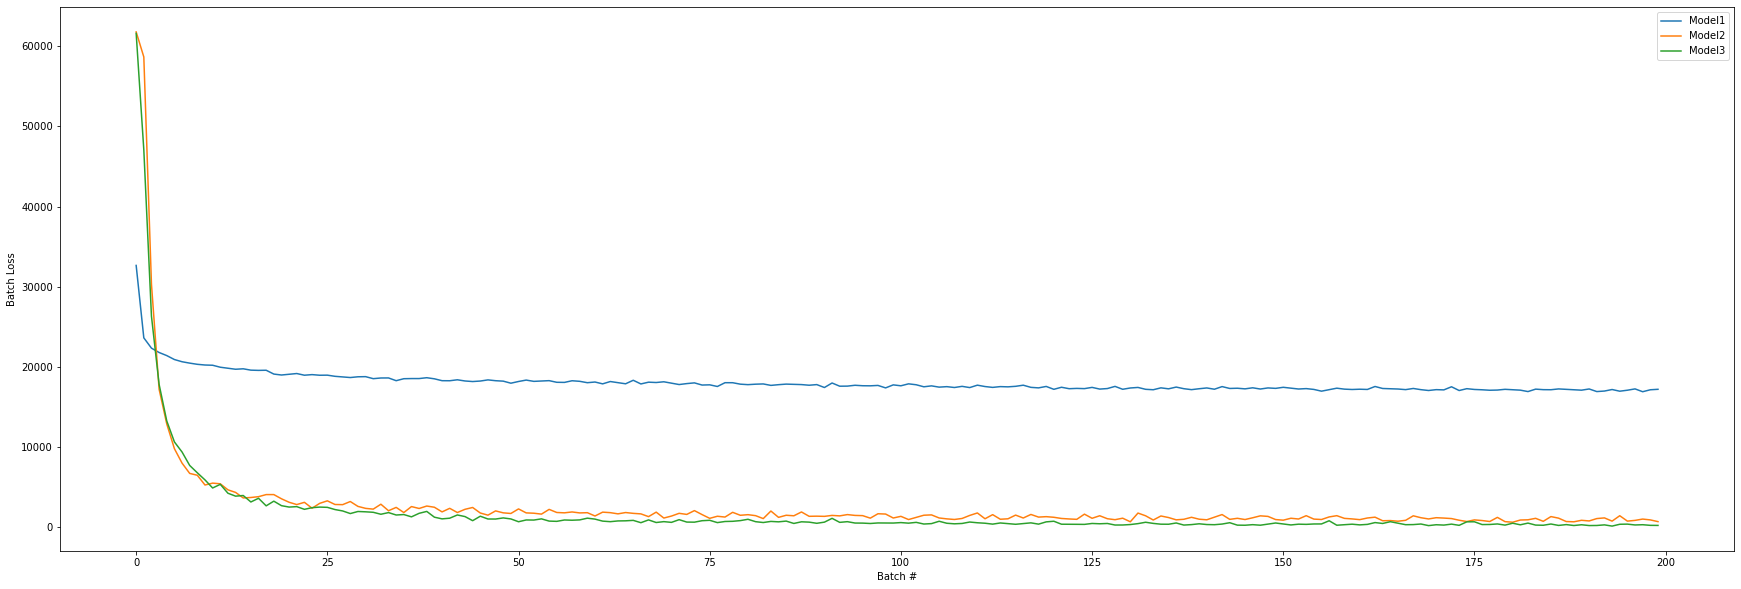

In [20]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(train_losses1)), train_losses1, label="Model1")
plt.plot(range(len(train_losses2)), train_losses2, label="Model2")
plt.plot(range(len(train_losses3)), train_losses3, label="Model3")
plt.xlabel('Batch #')
plt.ylabel('Batch Loss')
plt.legend()
plt.show()

In [17]:
with open("ProcessedData/test_sequences_padded_dataset.pkl", "rb") as file:
    test_sequences_padded_dataset = pickle.load(file)

test_loader = torch.utils.data.DataLoader(test_sequences_padded_dataset, batch_size=1)

seq = iter(test_loader).next()[0]
print(seq)
seq = seq.view(1, -1)

tensor([[0, 0, 0, 0, 0]])


In [18]:
model.eval()

seq = torch.tensor([[28, 28, 28, 28, 28]])

y = torch.ones([100, 1], dtype=torch.long)      # 100 vendors
seq_dupe = y @ seq                              # 100 x 5 matrix
v_ids = torch.arange(start=1, end=101, dtype=torch.long)
rankings = model.forward(c_seq=seq_dupe, v_id=v_ids).view(-1)    
top_k = torch.topk(rankings, 5)[1][:5]          # Essentially argmax for top k
top_k = top_k + 1

print(rankings.sort(descending=True))
print(len(rankings.tolist()))
print(top_k)

torch.return_types.sort(
values=tensor([-12.6975, -12.7094, -12.7171, -12.7614, -12.7698, -12.7762, -12.7812,
        -12.7857, -12.8266, -12.8305, -12.8331, -12.8411, -12.8421, -12.8603,
        -12.8632, -12.8645, -12.8667, -12.8947, -12.8977, -12.9145, -12.9179,
        -12.9208, -12.9216, -12.9245, -12.9641, -12.9657, -12.9681, -12.9697,
        -12.9822, -12.9962, -13.0036, -13.0114, -13.0287, -13.0298, -13.0415,
        -13.0483, -13.0557, -13.0621, -13.0651, -13.0799, -13.0801, -13.0817,
        -13.0871, -13.1070, -13.1123, -13.1298, -13.1299, -13.1571, -13.1948,
        -13.1996, -13.2026, -13.2141, -13.2187, -13.2206, -13.2470, -13.2529,
        -13.2943, -13.3196, -13.3289, -13.3397, -13.3948, -13.4030, -13.4047,
        -13.4566, -13.4988, -13.5875, -13.6118, -13.6400, -13.6506, -13.6649,
        -13.6687, -13.7780, -14.0279, -14.0395, -14.0439, -14.0530, -14.0730,
        -14.1371, -14.2297, -14.2320, -14.2604, -14.3297, -14.3577, -14.3965,
        -14.4433, -14.4679, -14.

In [19]:
top_k + 1

tensor([69, 91, 65, 54, 31])